In [1]:
# Load a model from file
# import joblib
# joblib.load('model_rf_spt.joblib')

# 🚀 Initialize and define functions

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate the compressor control voltage (vdc) based on fan speed and power
def compressor_vdc(fan_speed, power, power_low):
    # Initialize the vdc Series with zeros and the same length as fan_speed
    vdc = pd.Series(0, index=fan_speed.index)
    
    # Conditions for calculating vdc
    condition = (fan_speed >= 49) & (power > power_low)
    vdc[condition] = (fan_speed[condition] / 100 + 0.0179) / 0.2073
    
    # Apply maximum limit for vdc
    vdc[vdc > 4.91] = 4.91
    
    # Ensure vdc does not go below 0 (assuming this was meant to apply to vdc, not p, based on context)
    vdc[vdc < 0] = 0
    
    return vdc

# Define a function to calculate the compressor speed ratio based on vdc
def comp_spd_ratio(vdc):
    # Comp Speed Ratio Coefficients (vdc >= 2.42)
    m1 = (1 - 0.317) / (4.91 - 2.42)
    b1 = 0.317 - 2.42 * m1
    # Comp Speed Ratio Coefficients (vdc < 2.42)
    m2 = 0.317 / 2.42
    
    # Initialize y with zeros
    y = pd.Series(0, index=vdc.index)
    
    # Conditions for selecting coefficients
    cond = vdc >= 2.42
    m = pd.Series(m2, index=vdc.index)  # Default to m2
    b = pd.Series(0, index=vdc.index)   # Default to 0
    
    # Update m and b based on condition
    m[cond] = m1
    b[cond] = b1
    
    # Calculate compressor speed ratio
    y = m * vdc + b
    
    return y

# Define a function to calculate accumulated error 
def accumulated_errors(pv, spt, criteria_series, reset_threshold):
    """
    Calculate accumulated errors based on a process variable (pv),
    setpoint (spt), and a criteria series that determines when to reset
    the accumulated error based on the reset threshold.

    Parameters:
    - pv: Pandas Series representing the process variable or temperature.
    - spt: Pandas Series representing the setpoint.
    - criteria_series: Pandas Series representing the criteria for resetting accumulation.
    - reset_threshold: Scalar value that defines the threshold for resetting.

    Returns:
    - Pandas Series representing the accumulated error.
    """
    # Initialize the accumulated error series with the same index as the input series
    acc_errors = pd.Series(0, index=pv.index)
    
    # Initialize a variable to keep track of the current accumulated error
    current_acc_error = 0
    
    # Determine system off state using rolling window
    system_off = criteria_series.rolling(window=15*12, min_periods=1).max() < reset_threshold

    # Iterate through the series by index
    for i in pv.index:
        if system_off[i]:
            # Reset accumulated error to 0 if power is below the threshold
            current_acc_error = 0
            # continue
        else:
            # Calculate the error as the difference between temperature and setpoint
            error = pv[i] - spt[i]
            # Check if adding the error exceeds the max accumulation limit
            if current_acc_error + error > 3000:
                # Here, we set the accumulated error to 3000 if adding the next error would exceed it
                current_acc_error = 3000
            else:
                if error > 0:
                    current_acc_error += error  # Accumulate the error within limit
                else:
                    current_acc_error += error # Reduce the accumulated error at a different rate
        
        # Assign the current accumulated error to the series
        acc_errors[i] = current_acc_error
    
    return acc_errors

# Define a function to calculate error change based on a given error series
def error_change(pv,spt):
    """
    Calculate the change of error.

    Parameters:
    - pv: Pandas Series representing the process variable or temperature.
    - spt: Pandas Series representing the setpoint.

    Returns:
    - Pandas Series representing the change in error.
    """
    # Calculate the error as the difference between pv and spt
    errors = pv - spt

    # Calculate the change in error
    d_errors = errors.diff()
    
    return d_errors


# 📤 Load data files

In [2]:
# Specify the data folder path
data_folder = 'data/'

# Get a list of all files in the data folder
files = os.listdir(data_folder)

# Print the list of files
print("Available data files:")
for i, file in enumerate(files):
    print(f"{i+1}. {file}")

Available data files:
1. Test_AtlantaShiftDefault_061623_1055.csv
2. Test_AtlantaSHiftExtSum_07162023_0005.csv
3. Test_AtlantaShiftSTD2019_04092023_2320.csv
4. Test_AtlantaTES_04222023_2302.csv
5. Test_Atlanta_Default_1hr_110123_1357.csv
6. Test_Atlanta_Default_MPC_Pretest_122723_1025.csv
7. Test_Atlanta_Default_random2_102623_2106.csv
8. Test_Atlanta_Default_random_102423_1727.csv
9. Test_Atlanta_Default_Random_102923_1331.csv
10. Test_BuffaloShiftDef_06022023_1805.csv
11. Test_BuffaloShiftDenseOcc_06142023_2109.csv
12. Test_BuffaloShiftExtSum_060323_2005.csv
13. Test_BuffaloShiftSaveBehave_06182023_0242.csv
14. Test_BuffaloShiftSTD2019_060723_1026.csv
15. Test_NewYorkShiftDef_03312023_1837.csv
16. Test_NewYorkShiftDenseOcc_04012023_2115.csv
17. Test_NewYorkShiftSTD2019_05312023_2327.csv
18. Test_TucsonShiftDef_032523_1125.csv
19. Test_TucsonShiftSaveBehav_03282023_2135.csv
20. Test_TusconShiftSTD2019_041123_2101.csv


# 🧹 Data preprocessing and feature analysis

i: 0, file: Test_AtlantaShiftDefault_061623_1055.csv
i: 1, file: Test_AtlantaSHiftExtSum_07162023_0005.csv
i: 2, file: Test_AtlantaShiftSTD2019_04092023_2320.csv
i: 3, file: Test_AtlantaTES_04222023_2302.csv
i: 4, file: Test_Atlanta_Default_1hr_110123_1357.csv
i: 5, file: Test_Atlanta_Default_MPC_Pretest_122723_1025.csv
i: 6, file: Test_Atlanta_Default_random2_102623_2106.csv
i: 7, file: Test_Atlanta_Default_random_102423_1727.csv
i: 8, file: Test_Atlanta_Default_Random_102923_1331.csv
i: 9, file: Test_BuffaloShiftDef_06022023_1805.csv
i: 10, file: Test_BuffaloShiftDenseOcc_06142023_2109.csv
i: 11, file: Test_BuffaloShiftExtSum_060323_2005.csv
i: 12, file: Test_BuffaloShiftSaveBehave_06182023_0242.csv
i: 13, file: Test_BuffaloShiftSTD2019_060723_1026.csv
i: 14, file: Test_NewYorkShiftDef_03312023_1837.csv
i: 15, file: Test_NewYorkShiftDenseOcc_04012023_2115.csv
i: 16, file: Test_NewYorkShiftSTD2019_05312023_2327.csv
i: 17, file: Test_TucsonShiftDef_032523_1125.csv
i: 18, file: Test_Tuc

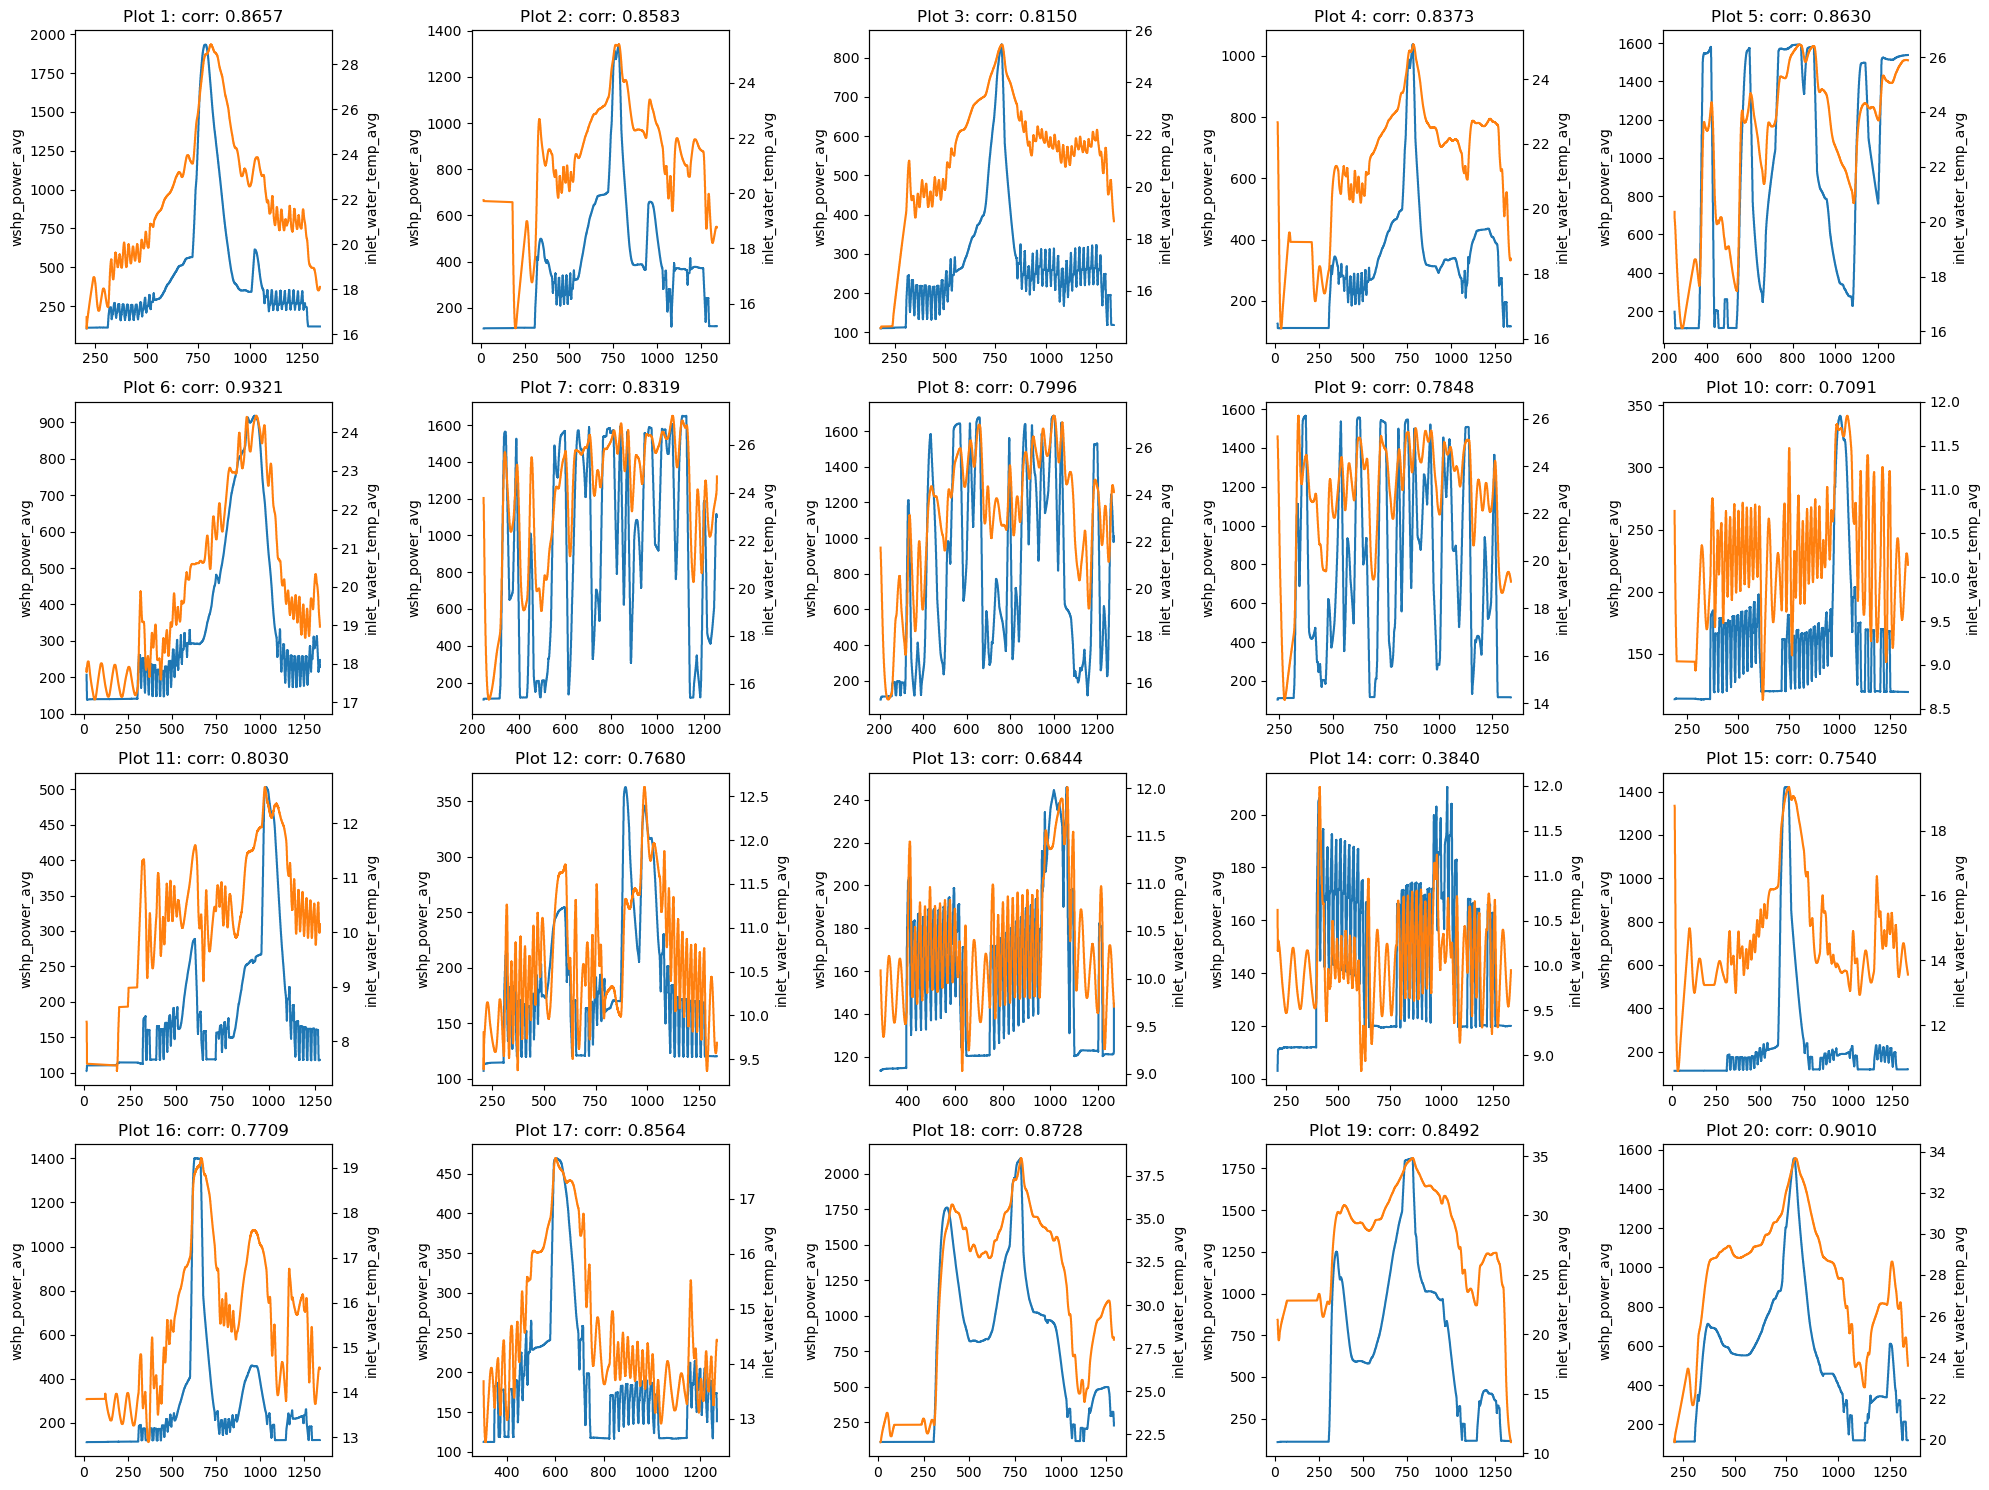

In [3]:
# Initialize empty pandas series to store the results of all iterations
# Data will be used for model training
comp_spd_avg_all_iterations = pd.Series(dtype='float')
acc_errors_avg_all_iterations = pd.Series(dtype='float')
errors_avg_all_iterations = pd.Series(dtype='float')
wshp_power_avg_all_iterations = pd.Series(dtype='float')
sim_zone_temp_avg_all_iterations = pd.Series(dtype='float')
active_setpoint_avg_all_iterations = pd.Series(dtype='float')
d_errors_avg_all_iterations = pd.Series(dtype='float')
inlet_water_temp_avg_all_iterations = pd.Series(dtype='float')

# Initialize a dictionary to store the results of each iteration
# Data will be used for verification
results = {}

# Set the subplot layout
n_rows = 4  # Adjust based on the number of plots
n_cols = 5  # Adjust based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the file paths
for i, file in enumerate(files):

    # Get the file path of the selected file
    file_path = os.path.join(data_folder, file)
    print(f"i: {i}, file: {file}")

    # Read the csv file
    data = pd.read_csv(file_path)

    # Remove rows where 'Simulation Time Step' is <= 0 and >=1339
    data = data[data['Simulation Time Step'] > 0]
    data = data[data['Simulation Time Step'] < 1339]
    data = data.reset_index(drop=True)

    # Extract column 'Current Simulation Step'
    simulation_time_step = data['Simulation Time Step']
    # Extract column that contains 'Sim Zone Temp'
    sim_zone_temp = data.filter(like='Sim Zone Temp').iloc[:, 0]
    # Extract column that contains 'Active Setpoint'
    active_setpoint = data.filter(like='Active Setpoint').iloc[:, 0]
    # Extract column that contains 'Fan Speed'
    fan_speed = data.filter(like='Fan Speed').iloc[:, 0]
    # Extract column that contains 'WSHP Power'
    wshp_power = data.filter(like='WSHP Power').iloc[:, 0]
    # Check if 'CompSpd' column exists
    if 'CompSpd' in data.columns:
        # Extract column 'CompSpd'
        vdc_recorded = data['CompSpd']
    else:
        vdc_recorded = None
    # Extract column that contains 'Inlet Water Temp'
    inlet_water_temp = data.filter(like='Inlet Water Temp').iloc[:, 0]  

    # Calculate the error between 'Sim Zone Temp' and 'Active Setpoint'
    errors = sim_zone_temp - active_setpoint

    # Calculate vdc based on fan speed and power
    vdc = compressor_vdc(fan_speed, wshp_power, 150)

    # Calculate the RMSE between vdc and vdc_recorded
    if vdc_recorded is not None:
        rmse = ((vdc - vdc_recorded) ** 2).mean() ** 0.5
        # print(f"RMSE between vdc and vdc_recorded: {rmse:.4f}")

    # Calculatre the compressor speed ratio based on vdc
    comp_spd = comp_spd_ratio(vdc)

    # Calculate min_avg minutes moving average of wshp_power
    min_avg = 15
    wshp_power_avg = wshp_power.rolling(min_avg*12).mean()

    # Calculate the accumulated errors
    criteria_series = wshp_power_avg
    reset_threshold = 150
    acc_errors = accumulated_errors(sim_zone_temp, active_setpoint, criteria_series, reset_threshold)

    # Calculate the change in error
    d_errors = error_change(sim_zone_temp, active_setpoint)

    # Calculate min_avg minutes moving average of other data
    comp_spd_avg = comp_spd.rolling(min_avg*12).mean()
    acc_errors_avg = acc_errors.rolling(min_avg*12).mean()
    errors_avg = errors.rolling(min_avg*12).mean()
    sim_zone_temp_avg = sim_zone_temp.rolling(min_avg*12).mean()
    active_setpoint_avg = active_setpoint.rolling(min_avg*12).mean()
    d_errors_avg = d_errors.rolling(min_avg*12).mean()
    inlet_water_temp_avg = inlet_water_temp.rolling(min_avg*12).mean()

    # Store the results of each iteration in a dictionary
    results[i] = {'comp_spd_avg': comp_spd_avg, 
                'acc_errors_avg': acc_errors_avg, 
                'errors_avg': errors_avg, 
                'wshp_power_avg': wshp_power_avg, 
                'simulation_time_step': simulation_time_step,
                'sim_zone_temp_avg': sim_zone_temp_avg,
                'active_setpoint_avg': active_setpoint_avg,
                'd_errors_avg': d_errors_avg,
                'errors': errors,
                'acc_errors': acc_errors,
                'd_errors': d_errors,
                'inlet_water_temp_avg': inlet_water_temp_avg
                }

    # Store part of the data for model development
    if i not in [999]:  

        # Concatenate the results of each iteration to the main Series
        errors_avg_all_iterations = pd.concat([errors_avg_all_iterations, errors_avg], ignore_index=True)
        acc_errors_avg_all_iterations = pd.concat([acc_errors_avg_all_iterations, acc_errors_avg], ignore_index=True)
        d_errors_avg_all_iterations = pd.concat([d_errors_avg_all_iterations, d_errors_avg], ignore_index=True)
        comp_spd_avg_all_iterations = pd.concat([comp_spd_avg_all_iterations, comp_spd_avg], ignore_index=True)
        wshp_power_avg_all_iterations = pd.concat([wshp_power_avg_all_iterations, wshp_power_avg], ignore_index=True)
        sim_zone_temp_avg_all_iterations = pd.concat([sim_zone_temp_avg_all_iterations, sim_zone_temp_avg], ignore_index=True)
        active_setpoint_avg_all_iterations = pd.concat([active_setpoint_avg_all_iterations, active_setpoint_avg], ignore_index=True)
        inlet_water_temp_avg_all_iterations = pd.concat([inlet_water_temp_avg_all_iterations, inlet_water_temp_avg], ignore_index=True)
    
    # Assign values to y1 and y2
    candidate = ['wshp_power_avg',
                 'acc_errors_avg',
                 'comp_spd_avg',
                 'sim_zone_temp_avg',
                 'active_setpoint_avg',
                 'd_errors_avg',
                 'errors_avg',
                 'inlet_water_temp_avg']
    y1 = results[i][candidate[0]]; y1_label = candidate[0]
    y2 = results[i][candidate[7]]; y2_label = candidate[7]
    title = f'{candidate[0]} vs {candidate[7]}'
    corr = y1.corr(y2)

    # Get the current color cycle
    current_cycler = plt.rcParams['axes.prop_cycle']
    colors = current_cycler.by_key()['color']

    # Two y-axes plot
    ax = axes[i]
    ax2 = ax.twinx()
    ax.plot(simulation_time_step, y1, color=colors[0])
    ax2.plot(simulation_time_step, y2, color=colors[1])
    ax.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    ax.set_title(f'Plot {i+1}: corr: {corr:.4f}')

    # ax = axes[i]
    # ax.plot(simulation_time_step, y1, color=colors[0], label=y1_label)
    # ax.plot(simulation_time_step, y2, color=colors[1], label=y2_label)
    # ax.set_title(f'Plot {i+1}: corr: {corr:.4f}')
    # ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# 🤖 Power = F(Error, Accumulated Error, Inlet Water Temperature)
This model is to predict power treating WSHP as a black box, i.e., compressor speed is not known.

## 🧩 Data preperation

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# Combine errors_avg, acc_errors_avg, and comp_spd_avg into a single DataFrame and provide column names
df = pd.DataFrame({'errors': errors_avg_all_iterations,
                   'acc_errors': acc_errors_avg_all_iterations,
                   'd_errors': d_errors_avg_all_iterations,
                   'comp_spd': comp_spd_avg_all_iterations,
                   'wshp_power': wshp_power_avg_all_iterations,
                   'inlet_water_temp': inlet_water_temp_avg_all_iterations})

# Drop rows with null values
df = df.dropna()

# Split the data into features (X) and target variable (y)
X = df[['errors', 'acc_errors', 'inlet_water_temp']]
# X = df[['errors', 'acc_errors', 'd_errors']]
y = df['wshp_power']

## 🧐 Model validation

### 🗺️ Grid search with cross validation

Parameter 1

In [6]:
from sklearn.model_selection import GridSearchCV

# Model selection
model = RandomForestRegressor(random_state=0)

# Define a range of parameters to explore
param_grid = {'n_estimators': [10, 50, 100, 200, 300]}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=10,  # Number of folds in cross-validation
                           scoring='neg_root_mean_squared_error',  # Example scoring metric
                           verbose=1,  # Show progress
                           n_jobs=-1)  # Use all CPU cores

# Perform the grid search
grid_search.fit(X, y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'n_estimators': [10, 50, 100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=1)

Parameter 1 grid search performance

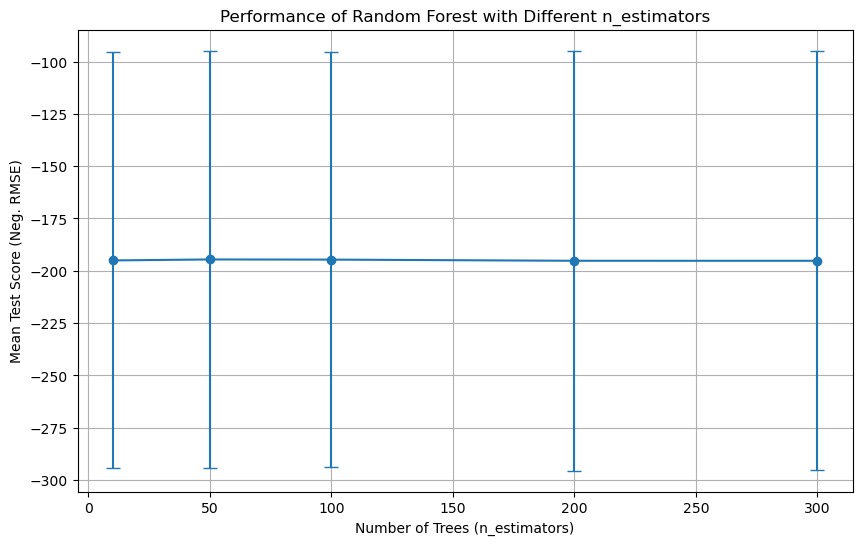

In [7]:
# Extract grid search results
results_estimators = pd.DataFrame(grid_search.cv_results_)

# Columns of interest
columns = ['param_n_estimators', 'mean_test_score', 'std_test_score']

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(results_estimators['param_n_estimators'], 
             results_estimators['mean_test_score'], 
             yerr=results_estimators['std_test_score'], 
             fmt='-o', capsize=5)
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Test Score (Neg. RMSE)')
plt.title('Performance of Random Forest with Different n_estimators')
plt.grid(True)
plt.show()

Parameter 2

In [9]:
# Model selection
model = RandomForestRegressor(random_state=0)

# Define a range of `max_depth` values to explore
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50]  # None means no maximum depth
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=10,  # Number of folds in cross-validation
                           scoring='neg_root_mean_squared_error',  # Example scoring metric
                           verbose=1,  # Show progress
                           n_jobs=-1)  # Use all CPU cores

# Perform the grid search
grid_search.fit(X, y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50]},
             scoring='neg_root_mean_squared_error', verbose=1)

Parameter 2 grid search performance

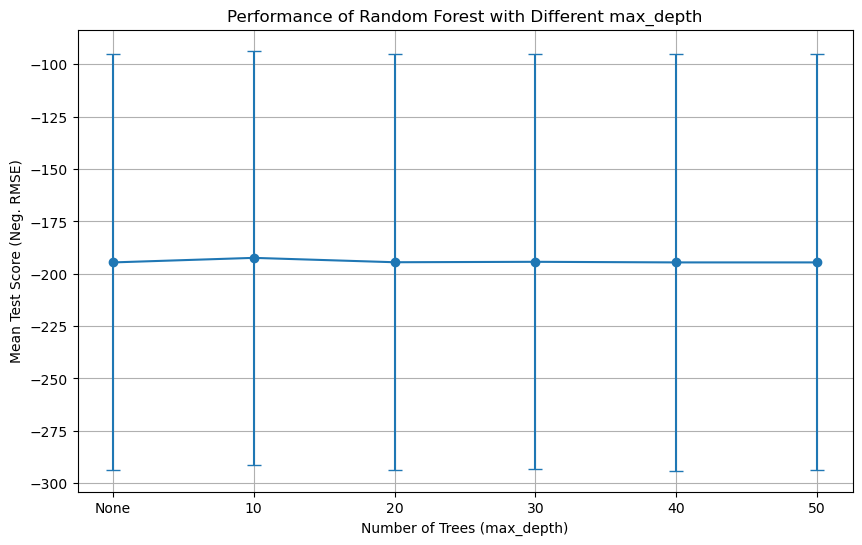

In [11]:
# Extract grid search results
results_estimators = pd.DataFrame(grid_search.cv_results_)

# Columns of interest
columns = ['param_max_depth', 'mean_test_score', 'std_test_score']

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(results_estimators['param_max_depth'].astype(str), 
             results_estimators['mean_test_score'], 
             yerr=results_estimators['std_test_score'], 
             fmt='-o', capsize=5)
plt.xlabel('Number of Trees (max_depth)')
plt.ylabel('Mean Test Score (Neg. RMSE)')
plt.title('Performance of Random Forest with Different max_depth')
plt.grid(True)
plt.show()

### 🔁 k-fold validation

RMSE scores: [222.61025652 166.05783459 192.19229567 203.34650094 174.9056903
  61.07631973  22.24517054 283.48180665 225.57934786 394.9769884 ]
Average RMSE: 194.6472211197275


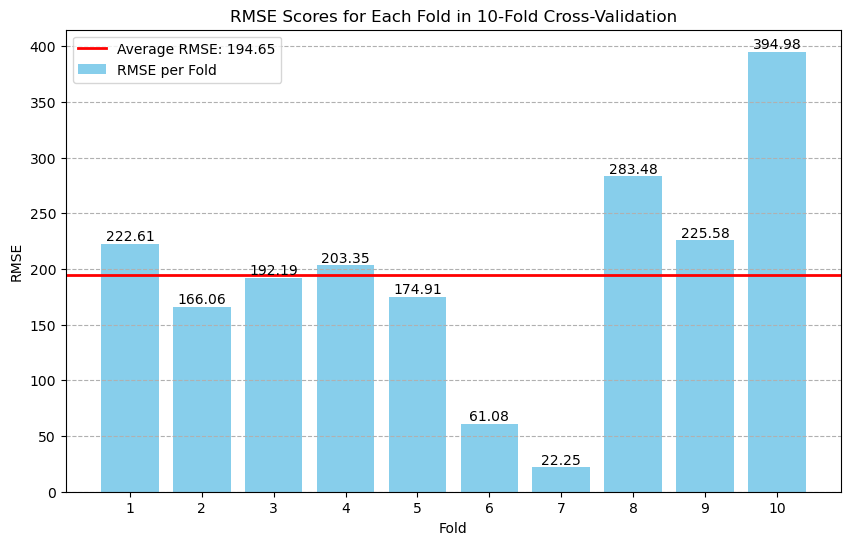

Overall RMSE: 16.90480589086716


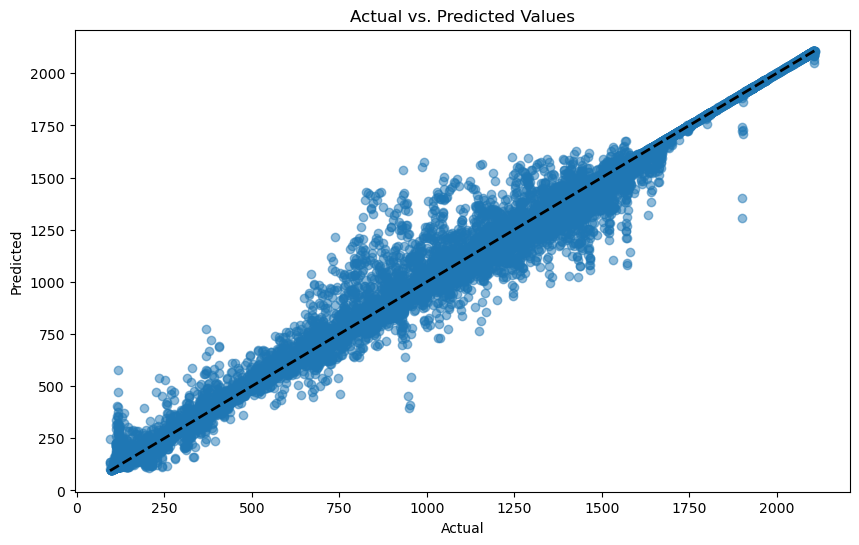

In [53]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

# Model selection
model = RandomForestRegressor(random_state=0)
# model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

# Perform k-fold cross-validation using RMSE
rmse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Print the RMSE scores and their average
print(f"RMSE scores: {-rmse_scores}")
print(f"Average RMSE: {np.mean(-rmse_scores)}")

# Convert negative RMSE scores to positive
rmse_scores_positive = -rmse_scores

# Calculate the average RMSE
average_rmse = np.mean(rmse_scores_positive)

# Visualization
plt.figure(figsize=(10, 6))
folds = np.arange(1, len(rmse_scores_positive) + 1)
plt.bar(folds, rmse_scores_positive, color='skyblue', label='RMSE per Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Scores for Each Fold in 10-Fold Cross-Validation')
plt.xticks(folds)  # Ensure each fold is marked
plt.grid(axis='y', linestyle='--')

# Plot the average RMSE
plt.axhline(y=average_rmse, color='r', linestyle='-', linewidth=2, label=f'Average RMSE: {average_rmse:.2f}')

# Add text labels above bars
for i, score in enumerate(rmse_scores_positive):
    plt.text(i + 1, score, f'{score:.2f}', ha = 'center', va = 'bottom')

# Add legend to the plot to clarify elements
plt.legend()

plt.show()

# Setup k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Get predictions for each fold
y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

# Calculate RMSE for the overall predictions
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Overall RMSE: {rmse}")

# Visualization of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


### Manual split

In [6]:
# Validation using the manual split
for i in [3, 676, 56, 2132, 23]:

    # Mannually split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions using two sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the RMSE of the model
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"RMSE of training set: {rmse_train:.4f}")
    print(f"RMSE of testing set: {rmse_test:.4f}")

RMSE of training set: 261.4350
RMSE of testing set: 262.4618
RMSE of training set: 261.7574
RMSE of testing set: 261.1743
RMSE of training set: 262.3437
RMSE of testing set: 258.8088
RMSE of training set: 261.9384
RMSE of testing set: 260.4502
RMSE of training set: 261.8123
RMSE of testing set: 260.9512


## 🏋️‍♂️ Model training

### Training

In [6]:
# Model selection
model = RandomForestRegressor(random_state=0)
# model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

# Train the model on the entire dataset
model.fit(X, y)

RandomForestRegressor(random_state=0)

### Metrics: Feature importance

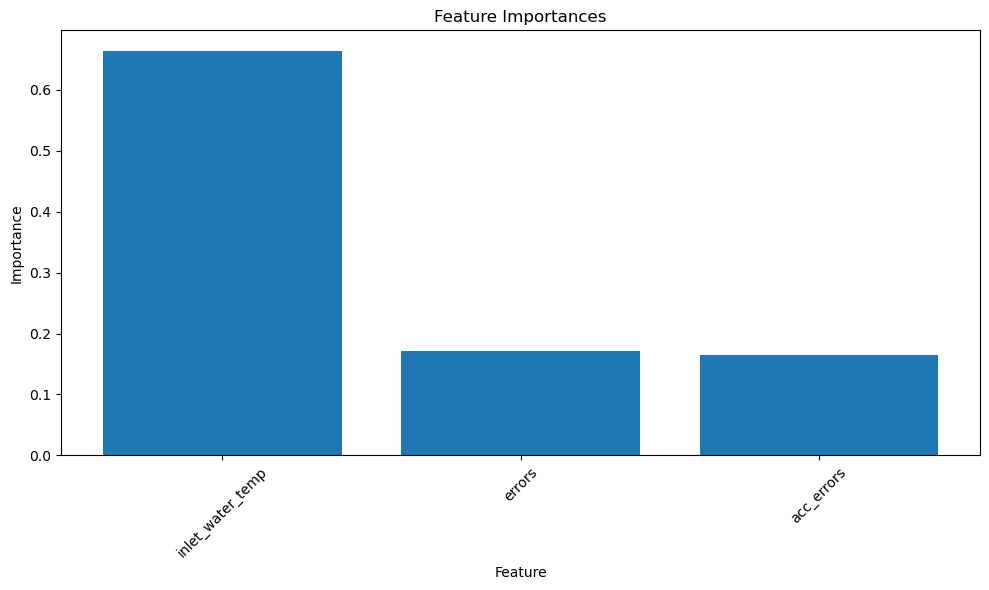

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


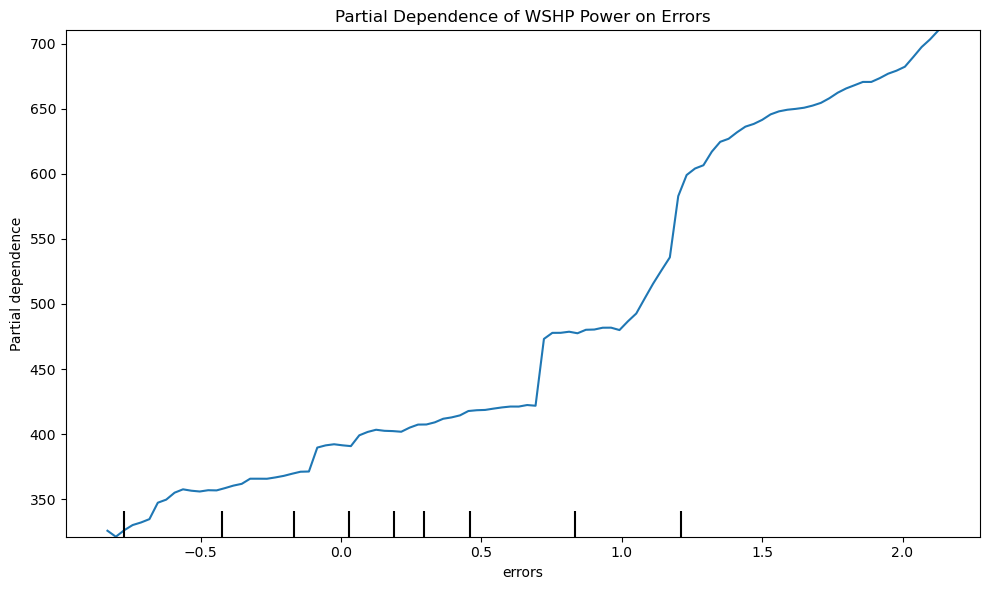

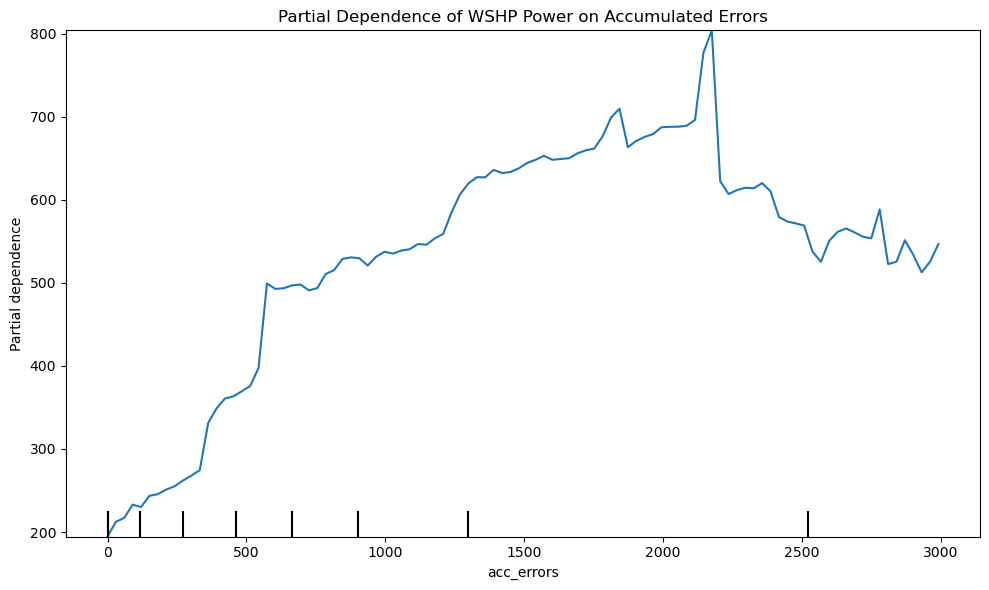

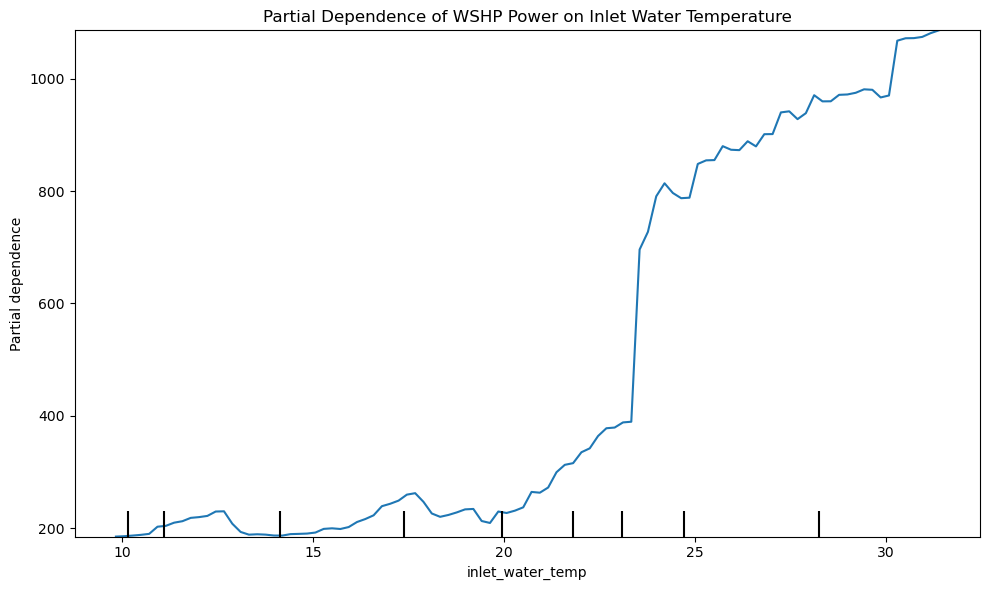

In [8]:
# Print the OOB score
# print(f"OOB Score (R^2): {model.oob_score_}")

# Save the model to a file
# import joblib
# joblib.dump(model, 'model_rf_pwr.joblib')

# Find the maximum depth
# depths = [tree.get_depth() for tree in model.estimators_]
# max_depth = max(depths)
# print(f"Maximum depth among all trees: {max_depth}")

# Get feature importances
importances = model.feature_importances_

# Feature names from X
feature_names = X.columns

# Get the indices of the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Prepare labels sorted by importance
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Calculate partial dependence for the first feature
from sklearn.inspection import plot_partial_dependence

# Plot the partial dependence
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(model, X, features=[0], ax=ax)
plt.title('Partial Dependence of WSHP Power on Errors')
plt.tight_layout()
plt.show()

# Plot the partial dependence for the second feature
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(model, X, features=[1], ax=ax)
plt.title('Partial Dependence of WSHP Power on Accumulated Errors')
plt.tight_layout()
plt.show()

# Plot the partial dependence for the third feature
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(model, X, features=[2], ax=ax)
plt.title('Partial Dependence of WSHP Power on Inlet Water Temperature')
plt.tight_layout()
plt.show()


## ✍️ Manual validation

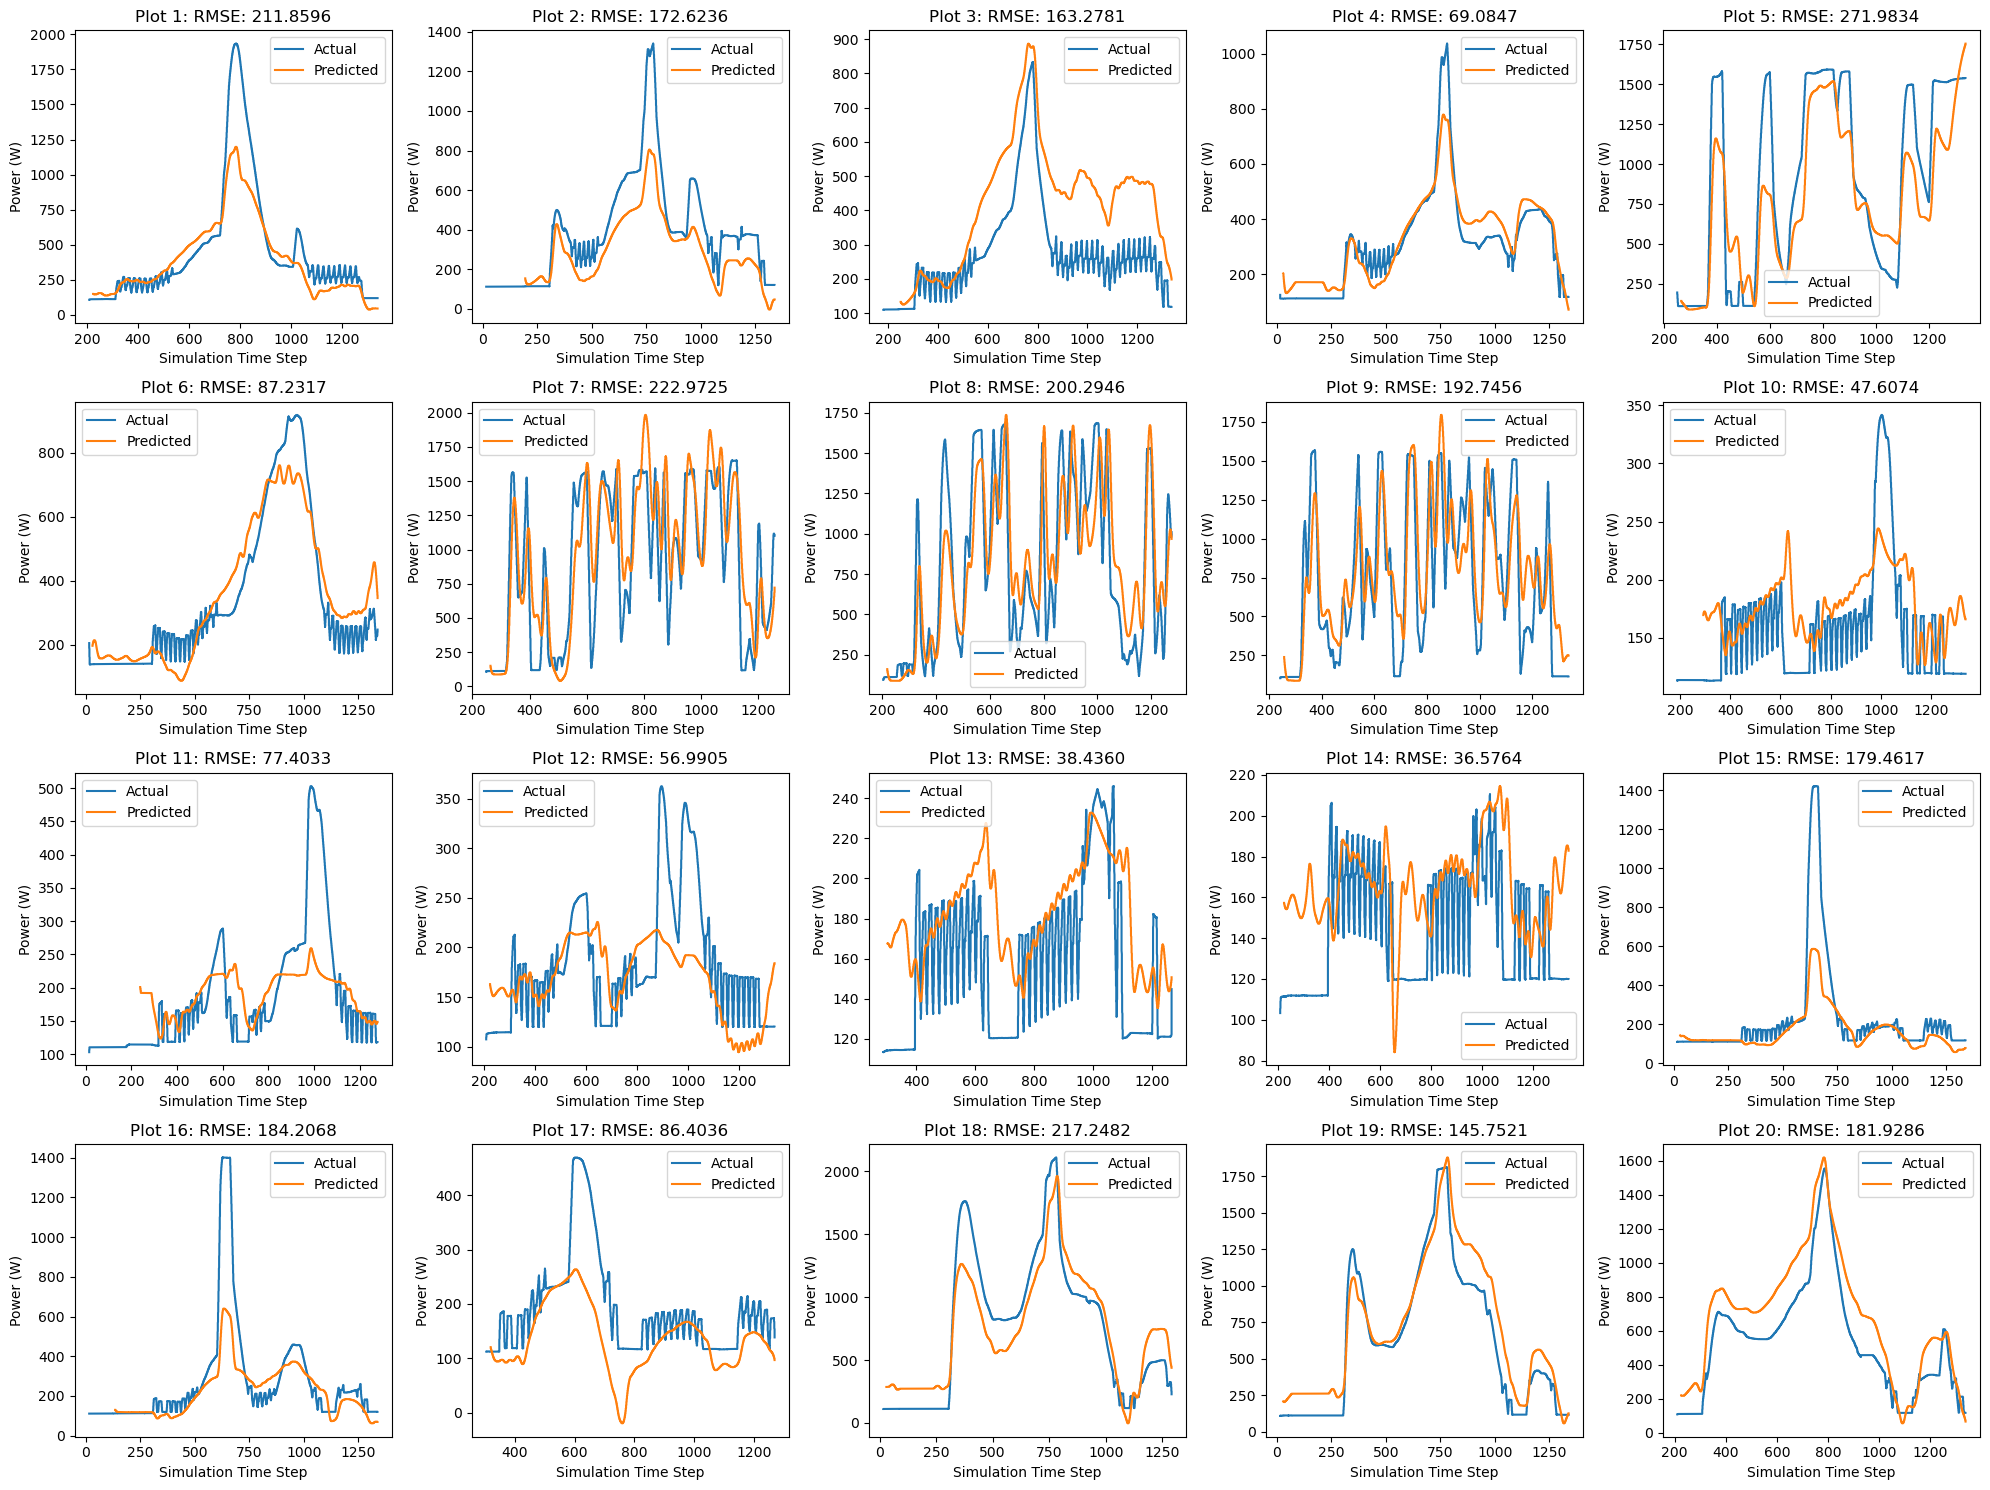

In [6]:
# Set the subplot layout
n_rows = 4  # Adjust based on the number of plots
n_cols = 5  # Adjust based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the file paths
for i, file in enumerate(files):

    # Combine the series into a single DataFrame
    df = pd.DataFrame({
        'comp_spd': results[i]['comp_spd_avg'],
        'errors': results[i]['errors_avg'],
        'acc_errors': results[i]['acc_errors_avg'],
        'd_errors': results[i]['d_errors_avg'],
        'wshp_power': results[i]['wshp_power_avg'],
        'simulation_time_step': results[i]['simulation_time_step'],
        'inlet_water_temp': results[i]['inlet_water_temp_avg']
    })

    # Drop rows with null values
    df = df.dropna()

    # Set the whole row to zero if any value in the row is NaN
    # df = df.fillna(0)

    # Assemble the feature space
    X = df[['errors', 'acc_errors', 'inlet_water_temp']]
    # X = df[['acc_errors']]
    # X = df[['errors', 'acc_errors', 'd_errors']]

    # Assemble the target variable
    # y_actual = df['comp_spd']
    y_actual = df['wshp_power']

    # Predict the target variable
    y_pred = model.predict(X)

    # Calculate the moving average of the predicted values
    min_avg = 15
    y_pred_avg = pd.Series(y_pred).rolling(min_avg*12).mean()

    # Calculate the RMSE between the actual and predicted compressor speed ratio
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse ** 0.5
    cvrmse = rmse / y_actual.mean()
    # print(f"RMSE: {rmse:.4f}")

    # Plot the actual and predicted values
    simulation_time_step = df['simulation_time_step']
    ax = axes[i]
    ax.plot(simulation_time_step, y_actual, label='Actual')
    ax.plot(simulation_time_step, y_pred_avg, label='Predicted')
    ax.set_xlabel('Simulation Time Step')
    ax.set_ylabel('Power (W)')
    # ax.set_title(f'Plot {i+1}: CVRMSE: {cvrmse:.4f}')
    ax.set_title(f'Plot {i+1}: RMSE: {rmse:.4f}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




# 🤖 Power = F(Inlet Water Temperature, Zone Temperature, Compressor Speed)
This model is to predict power if compressor speed is known.

## 🧩 Data preperation

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# Combine errors_avg, acc_errors_avg, and comp_spd_avg into a single DataFrame and provide column names
df = pd.DataFrame({'errors': errors_avg_all_iterations,
                   'acc_errors': acc_errors_avg_all_iterations,
                   'd_errors': d_errors_avg_all_iterations,
                   'comp_spd': comp_spd_avg_all_iterations,
                   'wshp_power': wshp_power_avg_all_iterations,
                   'inlet_water_temp': inlet_water_temp_avg_all_iterations,
                   'sim_zone_temp': sim_zone_temp_avg_all_iterations})

# Drop rows with null values
df = df.dropna()

# Split the data into features (X) and target variable (y)
X = df[['inlet_water_temp','sim_zone_temp','comp_spd']]
y = df['wshp_power']

## 🧐 Model validation

### 🔁 k-fold validation

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

# Model selection
model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

# Perform k-fold cross-validation using RMSE
rmse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Print the RMSE scores and their average
print(f"RMSE scores: {-rmse_scores}")
print(f"Average RMSE: {np.mean(-rmse_scores)}")

# Convert negative RMSE scores to positive
rmse_scores_positive = -rmse_scores

# Calculate the average RMSE
average_rmse = np.mean(rmse_scores_positive)

# Visualization
plt.figure(figsize=(10, 6))
folds = np.arange(1, len(rmse_scores_positive) + 1)
plt.bar(folds, rmse_scores_positive, color='skyblue', label='RMSE per Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Scores for Each Fold in 10-Fold Cross-Validation')
plt.xticks(folds)  # Ensure each fold is marked
plt.grid(axis='y', linestyle='--')

# Plot the average RMSE
plt.axhline(y=average_rmse, color='r', linestyle='-', linewidth=2, label=f'Average RMSE: {average_rmse:.2f}')

# Add text labels above bars
for i, score in enumerate(rmse_scores_positive):
    plt.text(i + 1, score, f'{score:.2f}', ha = 'center', va = 'bottom')

# Add legend to the plot to clarify elements
plt.legend()

plt.show()

# Setup k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Get predictions for each fold
y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

# Calculate RMSE for the overall predictions
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Overall RMSE: {rmse}")

# Visualization of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


## 🏋️‍♂️ Model training

### Training

In [ ]:
# Model selection
model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

# Train the model on the entire dataset
model.fit(X, y)

# 🤖 Compressor speed model development

## Data preperation and model selection

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Combine errors_avg, acc_errors_avg, and comp_spd_avg into a single DataFrame and provide column names
df = pd.DataFrame({'errors': errors_avg_all_iterations,
                   'acc_errors': acc_errors_avg_all_iterations,
                   'd_errors': d_errors_avg_all_iterations,
                   'comp_spd': comp_spd_avg_all_iterations,
                   'wshp_power': wshp_power_avg_all_iterations})

# Drop rows with null values
df = df.dropna()

# Split the data into features (X) and target variable (y)
X = df[['errors', 'acc_errors']]
y = df['comp_spd']

# Model selection
# model = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True, max_depth=10)
# model = LinearRegression(fit_intercept=True)
model = SVR(kernel='rbf')

## Model training

In [6]:
# Train the model on the entire dataset
model.fit(X, y)

# Print the OOB score
# print(f"OOB Score (R^2): {model.oob_score_}")

# Save the model to a file
# import joblib
# joblib.dump(model, 'model_rf_pwr.joblib')

# # Find the maximum depth
# depths = [tree.get_depth() for tree in model.estimators_]
# max_depth = max(depths)
# print(f"Maximum depth among all trees: {max_depth}")

SVR()

## Verification

In [8]:
# Set the subplot layout
n_rows = 4  # Adjust based on the number of plots
n_cols = 5  # Adjust based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the file paths
for i, file in enumerate(files):

    # Extract the series directly from the dictionary
    comp_spd_avg_temp = results[i]['comp_spd_avg']
    acc_errors_avg_temp = results[i]['acc_errors_avg']
    errors_avg_temp = results[i]['errors_avg']
    wshp_power_avg_temp = results[i]['wshp_power_avg']
    simulation_time_step_temp = results[i]['simulation_time_step']
    d_errors_avg_temp = results[i]['d_errors_avg']

    # Combine the series into a single DataFrame
    df = pd.DataFrame({
        'comp_spd': comp_spd_avg_temp,
        'errors': errors_avg_temp,
        'acc_errors': acc_errors_avg_temp,
        'd_errors': d_errors_avg_temp,
        'wshp_power': wshp_power_avg_temp,
        'simulation_time_step': simulation_time_step
    })

    # Drop rows with null values
    df = df.dropna()

    # Set the whole row to zero if any value in the row is NaN
    # df = df.fillna(0)

    # Assemble the feature space
    X = df[['errors', 'acc_errors']]

    # Assemble the target variable
    y_actual = df['comp_spd']

    # Predict the target variable
    y_pred = model.predict(X)

    # Calculate the moving average of the predicted values
    min_avg = 15
    y_pred_avg = pd.Series(y_pred).rolling(min_avg*12).mean()

    # Calculate the RMSE between the actual and predicted compressor speed ratio
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse ** 0.5
    cvrmse = rmse / y_actual.mean()
    # print(f"RMSE: {rmse:.4f}")

    # Plot the actual and predicted values
    simulation_time_step = df['simulation_time_step']
    ax = axes[i]
    ax.plot(simulation_time_step, y_actual, label='Actual')
    ax.plot(simulation_time_step, y_pred_avg, label='Predicted')
    ax.set_xlabel('Simulation Time Step')
    ax.set_ylabel('Power (W)')
    ax.set_title(f'Plot {i+1}: CVRMSE: {cvrmse:.4f}')
    # ax.set_title(f'Plot {i+1}: RMSE: {rmse:.4f}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




# 🤖 Temperature setpoint (or error) model development
Develop a model to predict the error. The error can then be used to back calculate a setpoint based on the current zone temperature that can lead to a desire compressor speed.

## 🧩 Data preperation

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# Combine errors_avg, acc_errors_avg, and comp_spd_avg into a single DataFrame and provide column names
df = pd.DataFrame({'errors': errors_avg_all_iterations,
                   'acc_errors': acc_errors_avg_all_iterations,
                   'd_errors': d_errors_avg_all_iterations,
                   'comp_spd': comp_spd_avg_all_iterations,
                   'wshp_power': wshp_power_avg_all_iterations,
                   'inlet_water_temp': inlet_water_temp_avg_all_iterations})

# Drop rows with null values
df = df.dropna()

# Split the data into features (X) and target variable (y)
X = df[['acc_errors', 'comp_spd']]
# X = df[['errors', 'acc_errors', 'd_errors']]
y = df['errors']

## 🧐 Model validation

### 🗺️ Grid search with cross validation

Parameter 1

In [7]:
from sklearn.model_selection import GridSearchCV

# Model selection
model = RandomForestRegressor(random_state=0)

# Define a range of parameters to explore
param_grid = {'n_estimators': [10, 50, 100, 200, 300]}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=10,  # Number of folds in cross-validation
                           scoring='neg_root_mean_squared_error',  # Example scoring metric
                           verbose=1,  # Show progress
                           n_jobs=-1)  # Use all CPU cores

# Perform the grid search
grid_search.fit(X, y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'n_estimators': [10, 50, 100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=1)

Parameter 1 grid search performance

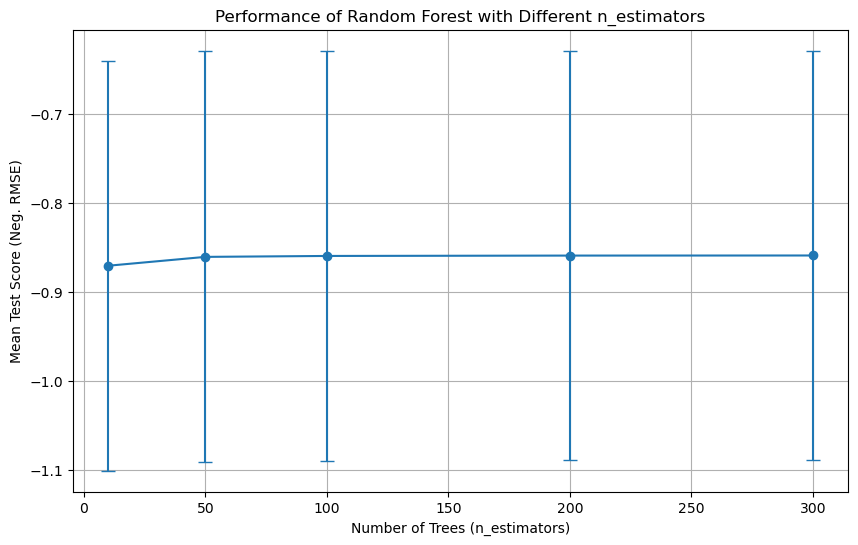

In [8]:
# Extract grid search results
results_estimators = pd.DataFrame(grid_search.cv_results_)

# Columns of interest
columns = ['param_n_estimators', 'mean_test_score', 'std_test_score']

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(results_estimators['param_n_estimators'], 
             results_estimators['mean_test_score'], 
             yerr=results_estimators['std_test_score'], 
             fmt='-o', capsize=5)
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Test Score (Neg. RMSE)')
plt.title('Performance of Random Forest with Different n_estimators')
plt.grid(True)
plt.show()

Parameter 2

In [13]:
# Model selection
model = RandomForestRegressor(random_state=0)

# Define a range of `max_depth` values to explore
param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]  # None means no maximum depth
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=10,  # Number of folds in cross-validation
                           scoring='neg_root_mean_squared_error',  # Example scoring metric
                           verbose=1,  # Show progress
                           n_jobs=-1)  # Use all CPU cores

# Perform the grid search
grid_search.fit(X, y)

Fitting 10 folds for each of 19 candidates, totalling 190 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19]},
             scoring='neg_root_mean_squared_error', verbose=1)

Parameter 2 grid search performance

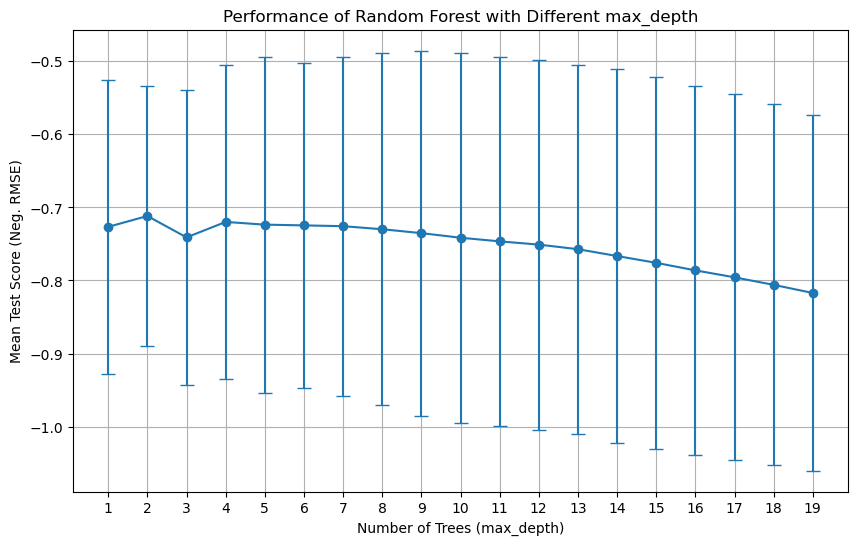

In [14]:
# Extract grid search results
results_estimators = pd.DataFrame(grid_search.cv_results_)

# Columns of interest
columns = ['param_max_depth', 'mean_test_score', 'std_test_score']

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(results_estimators['param_max_depth'].astype(str), 
             results_estimators['mean_test_score'], 
             yerr=results_estimators['std_test_score'], 
             fmt='-o', capsize=5)
plt.xlabel('Number of Trees (max_depth)')
plt.ylabel('Mean Test Score (Neg. RMSE)')
plt.title('Performance of Random Forest with Different max_depth')
plt.grid(True)
plt.show()

### 🔁 k-fold validation

RMSE scores: [0.65699433 0.49316083 0.79257291 1.08261736 0.90946611 0.51827596
 0.5484101  0.59410052 0.75354139 0.76951604]
Average RMSE: 0.7118655547832063


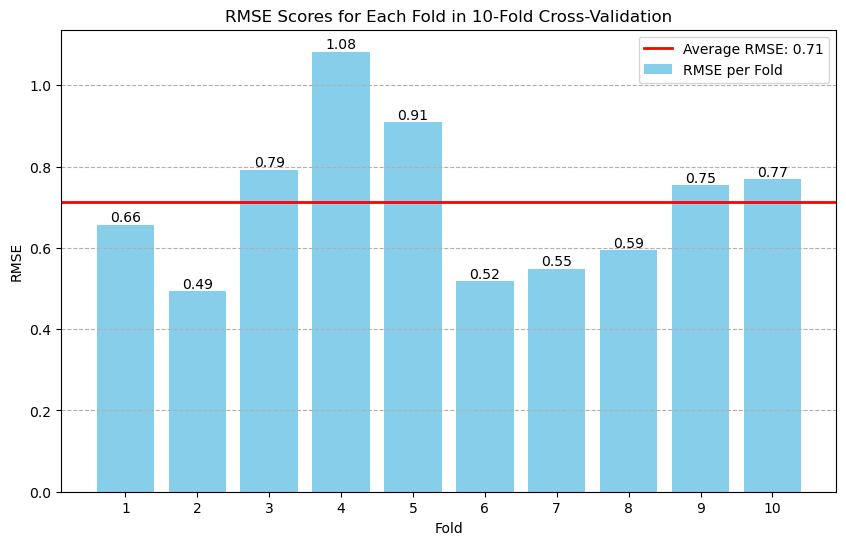

Overall RMSE: 0.7059937233816231


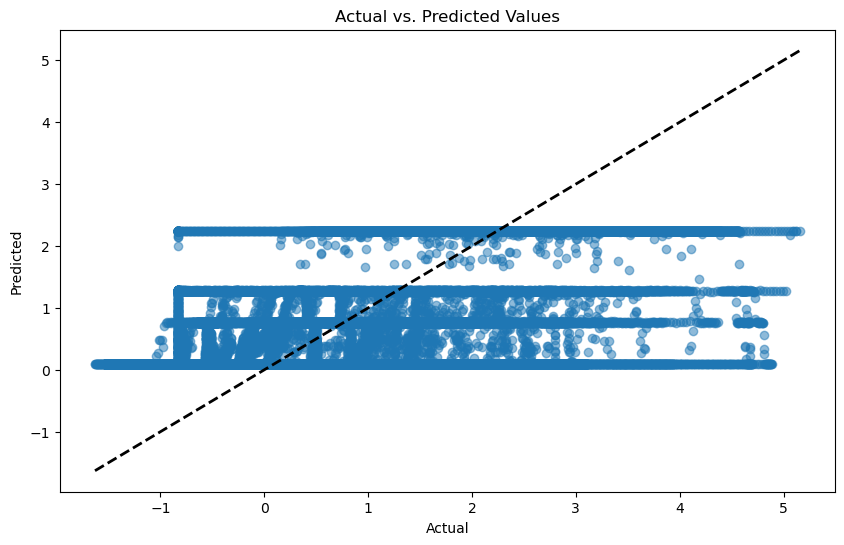

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

# Model selection
model = RandomForestRegressor(random_state=0, max_depth=2)
# model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

# Perform k-fold cross-validation using RMSE
rmse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Print the RMSE scores and their average
print(f"RMSE scores: {-rmse_scores}")
print(f"Average RMSE: {np.mean(-rmse_scores)}")

# Convert negative RMSE scores to positive
rmse_scores_positive = -rmse_scores

# Calculate the average RMSE
average_rmse = np.mean(rmse_scores_positive)

# Visualization
plt.figure(figsize=(10, 6))
folds = np.arange(1, len(rmse_scores_positive) + 1)
plt.bar(folds, rmse_scores_positive, color='skyblue', label='RMSE per Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Scores for Each Fold in 10-Fold Cross-Validation')
plt.xticks(folds)  # Ensure each fold is marked
plt.grid(axis='y', linestyle='--')

# Plot the average RMSE
plt.axhline(y=average_rmse, color='r', linestyle='-', linewidth=2, label=f'Average RMSE: {average_rmse:.2f}')

# Add text labels above bars
for i, score in enumerate(rmse_scores_positive):
    plt.text(i + 1, score, f'{score:.2f}', ha = 'center', va = 'bottom')

# Add legend to the plot to clarify elements
plt.legend()

plt.show()

# Setup k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Get predictions for each fold
y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

# Calculate RMSE for the overall predictions
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Overall RMSE: {rmse}")

# Visualization of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


### Manual split

In [ ]:
# Validation with manual split
for i in [3, 676, 56, 2132, 23]:

    # Mannually split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions using two sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the RMSE of the model
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"RMSE of training set: {rmse_train:.4f}")
    print(f"RMSE of testing set: {rmse_test:.4f}")

RMSE of training set: 0.1318
RMSE of testing set: 0.3491
RMSE of training set: 0.1312
RMSE of testing set: 0.3518
RMSE of training set: 0.1309
RMSE of testing set: 0.3541
RMSE of training set: 0.1305
RMSE of testing set: 0.3549
RMSE of training set: 0.1319
RMSE of testing set: 0.3463


## 🏋️‍♂️ Model training

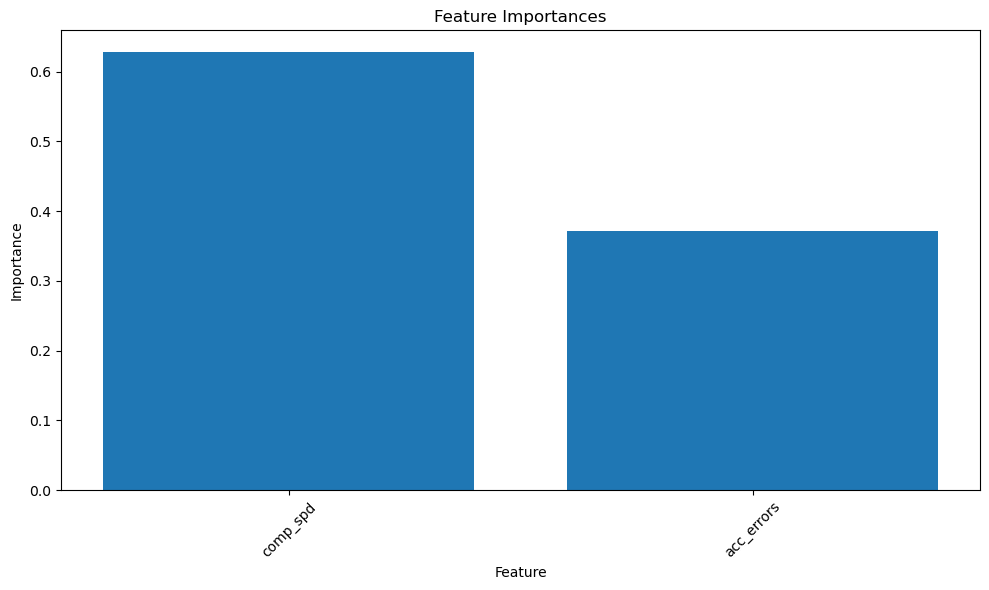

In [5]:
# Model selection
model = RandomForestRegressor(random_state=0)
# model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

# Train the model on the entire dataset
model.fit(X, y)

# Print the OOB score
# print(f"OOB Score (R^2): {model.oob_score_}")

# Save the model to a file
# import joblib
# joblib.dump(model, 'model_rf_pwr.joblib')

# Find the maximum depth
# depths = [tree.get_depth() for tree in model.estimators_]
# max_depth = max(depths)
# print(f"Maximum depth among all trees: {max_depth}")

# Get feature importances
importances = model.feature_importances_

# Feature names from X
feature_names = X.columns

# Get the indices of the importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Prepare labels sorted by importance
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## ✍️ Manual validation

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- wshp_power
Feature names seen at fit time, yet now missing:
- comp_spd

  warnings.warn(message, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- wshp_power
Feature names seen at fit time, yet now missing:
- comp_spd

  warnings.warn(message, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- wshp_power
Feature names seen at fit time, yet now missing:
- comp_spd

  warnings.warn(mess

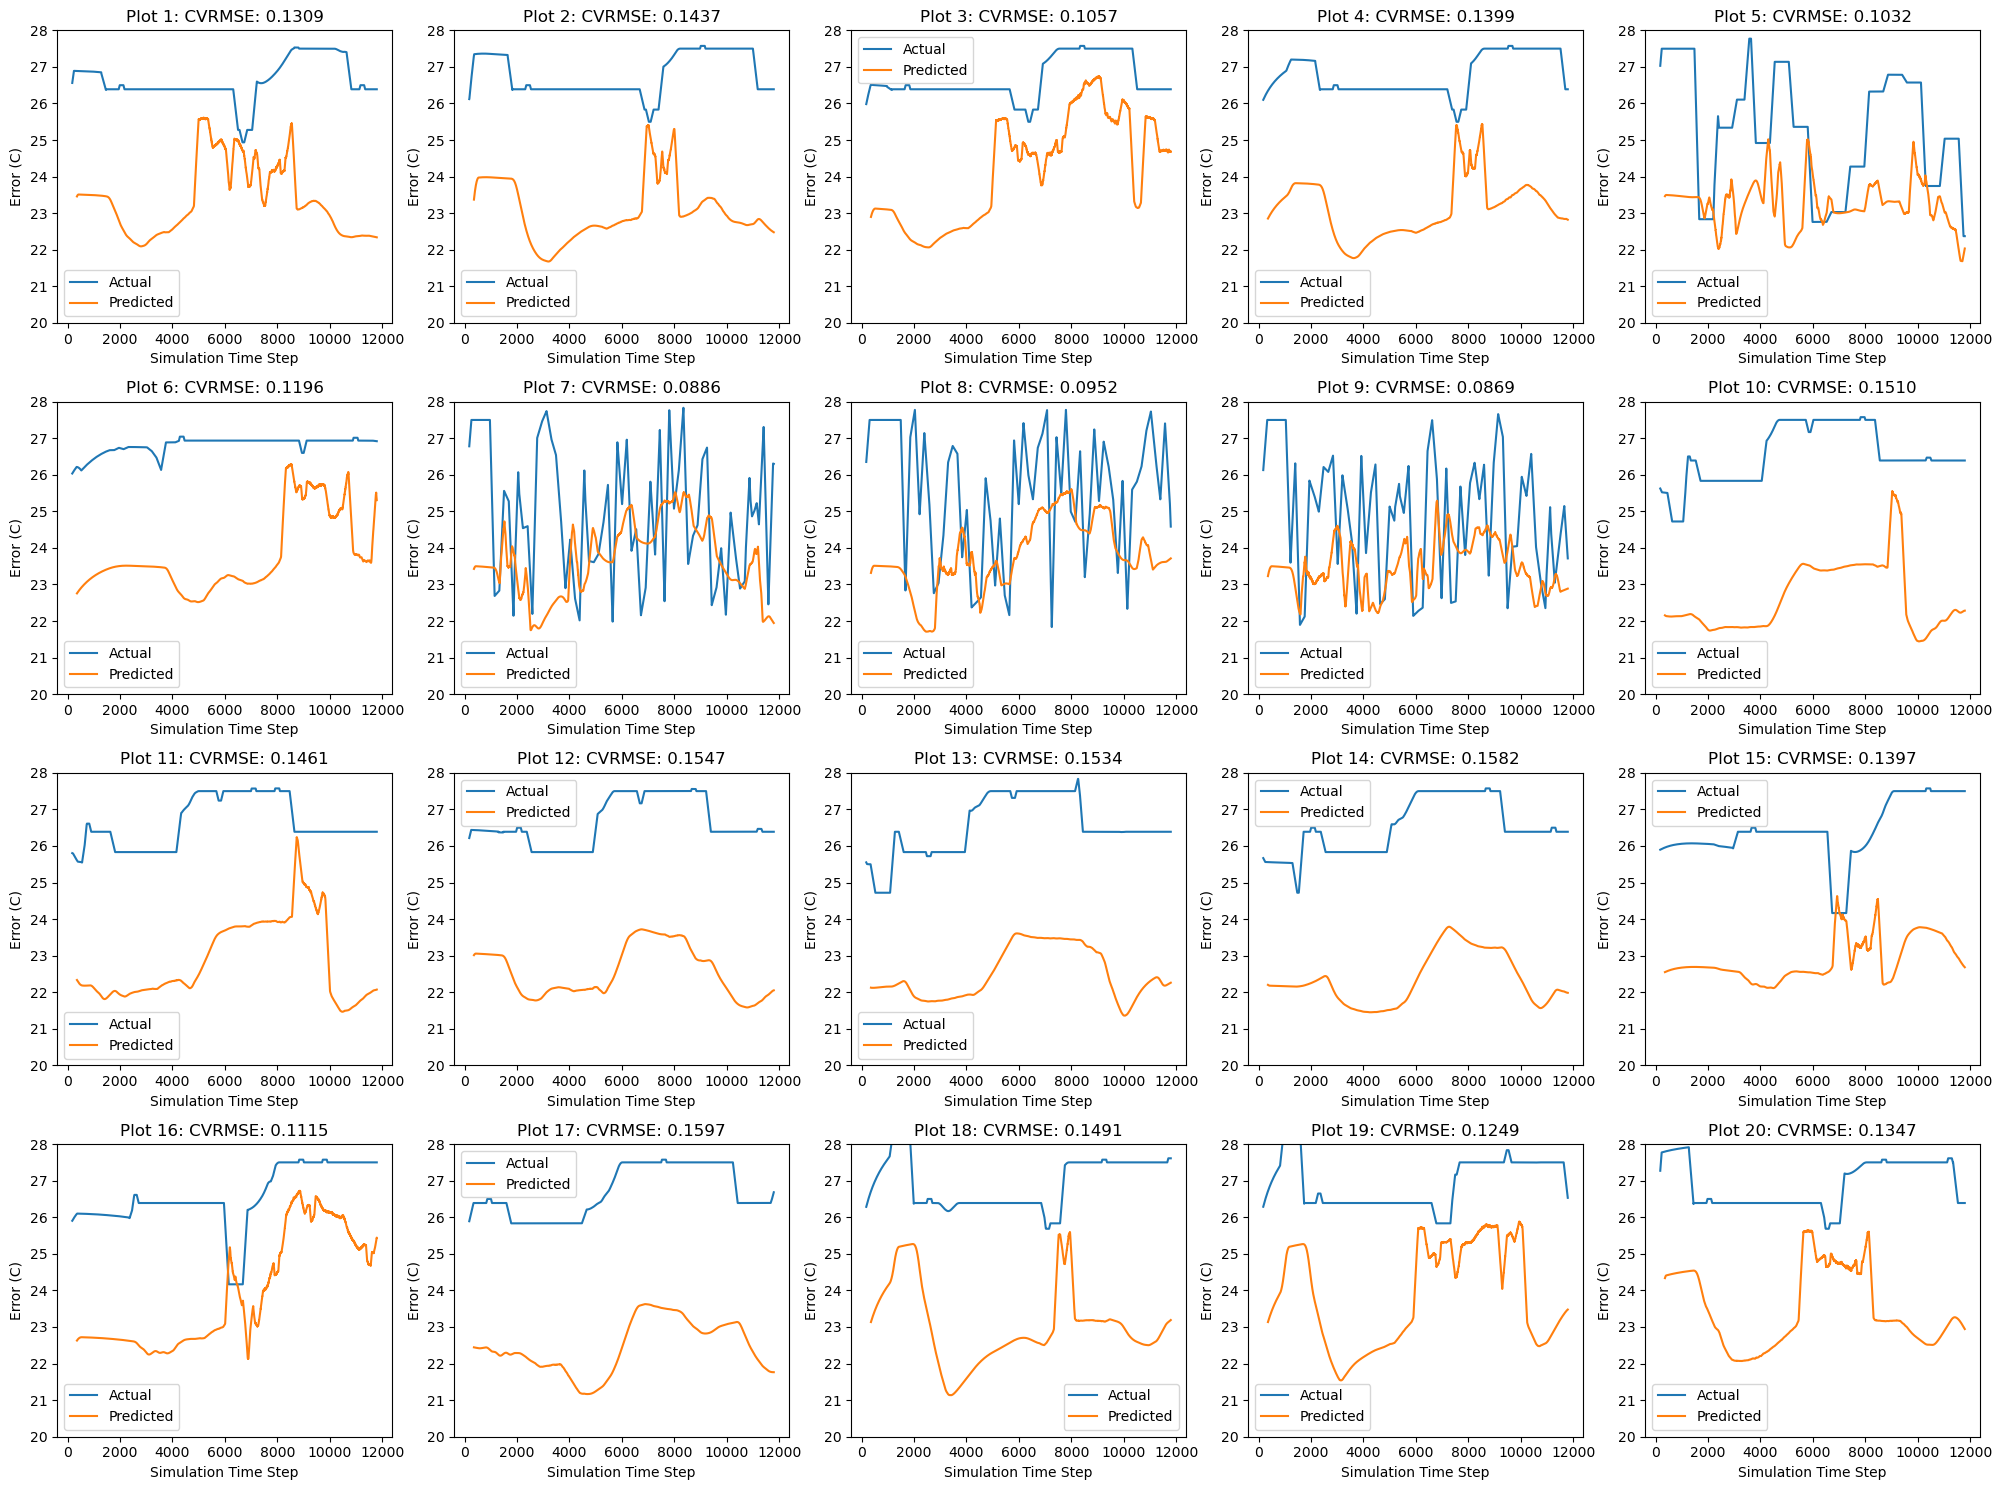

In [7]:
# Set the subplot layout
n_rows = 4  # Adjust based on the number of plots
n_cols = 5  # Adjust based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the file paths
for i, file in enumerate(files):

    # Extract the series directly from the dictionary
    comp_spd_avg_temp = results[i]['comp_spd_avg']
    acc_errors_avg_temp = results[i]['acc_errors_avg']
    errors_avg_temp = results[i]['errors_avg']
    wshp_power_avg_temp = results[i]['wshp_power_avg']
    simulation_time_step_temp = results[i]['simulation_time_step']
    sim_zone_temp_avg_temp = results[i]['sim_zone_temp_avg']
    active_setpoint_avg_temp = results[i]['active_setpoint_avg']

    # Combine the series into a single DataFrame
    df = pd.DataFrame({
        'comp_spd': comp_spd_avg_temp,
        'acc_errors': acc_errors_avg_temp,
        'errors': errors_avg_temp,
        'wshp_power': wshp_power_avg_temp,
        'simulation_time_step': simulation_time_step,
        'sim_zone_temp': sim_zone_temp_avg_temp,
        'active_setpoint': active_setpoint_avg_temp
    })

    # Drop rows with null values
    df = df.dropna()

    # Set the whole row to zero if any value in the row is NaN
    # df = df.fillna(0)

    # Assemble the feature space
    X = df[['acc_errors', 'wshp_power']]
    # X = df[['sim_zone_temp', 'wshp_power']]
    # X = df[['acc_errors']]

    # Assemble the target variable
    # y_actual = df['comp_spd']
    # y_actual = df['errors']
    y_actual = df['active_setpoint']

    # Predict the target variable
    y_pred = model.predict(X)
    y_pred = df['sim_zone_temp']-y_pred

    # Calculate the moving average of the predicted values
    min_avg = 15
    y_pred_avg = pd.Series(y_pred).rolling(min_avg*12).mean()

    # Calculate the RMSE between the actual and predicted compressor speed ratio
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse ** 0.5
    cvrmse = rmse / y_actual.mean()

    # # Plot the actual and predicted values
    # simulation_time_step = df['simulation_time_step']
    # plt.figure()
    # plt.scatter(simulation_time_step, y_actual, label='Actual', marker='o')
    # plt.scatter(simulation_time_step, y_pred_avg, label='Predicted', marker='x')
    # plt.xlabel('Simulation Time Step')
    # plt.ylabel('Error')
    # plt.title('Actual vs. Predicted Error')
    # plt.text(x=0.05, y=0.85, s=f'RMSE: {rmse:.3f}', ha='left', va='top', transform=plt.gca().transAxes)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    # Plotting in the specified subplot
    simulation_time_step = df['simulation_time_step']
    ax = axes[i]
    ax.plot(y_actual, label='Actual')
    ax.plot(y_pred_avg, label='Predicted')
    ax.set_xlabel('Simulation Time Step')
    ax.set_ylabel('Error (C)')
    ax.set_title(f'Plot {i+1}: CVRMSE: {cvrmse:.4f}')
    ax.legend()
    ax.set_ylim(20, 28)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
